In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import utils
%matplotlib inline
import importlib
importlib.reload(utils)
import seaborn as sns
from scipy.stats.mstats import winsorize

### Reading the dataset + clean and sort it in time order

In [94]:
df = pd.read_csv("stock data/Consumer Goods & Retail/MSN_RRV.csv")
df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/14/2025,"71,100","70,500","71,900","70,400",7.30M,0.99%
1,03/13/2025,"70,400","68,700","71,200","68,700",11.57M,2.47%
2,03/12/2025,"68,700","68,900","69,700","68,700",4.99M,-0.29%
3,03/11/2025,"68,900","68,200","68,900","68,100",4.53M,0.00%
4,03/10/2025,"68,900","69,000","69,900","68,700",5.12M,-0.14%
...,...,...,...,...,...,...,...
2897,08/02/2013,"88,500","88,500","89,000","88,000",128.92K,0.57%
2898,08/01/2013,"88,000","88,500","88,500","88,000",273.93K,-0.56%
2899,07/31/2013,"88,500","89,000","89,500","88,000",79.70K,-0.56%
2900,07/30/2013,"89,000","88,000","89,500","88,000",156.25K,0.56%


In [95]:
df = utils.clean(df)
df = utils.reverse_inplace(df)

In [96]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2013-07-29,88500.0,90000.0,91000.0,88000.0,155990.0,-1.67
1,2013-07-30,89000.0,88000.0,89500.0,88000.0,156250.0,0.56
2,2013-07-31,88500.0,89000.0,89500.0,88000.0,79700.0,-0.56
3,2013-08-01,88000.0,88500.0,88500.0,88000.0,273930.0,-0.56
4,2013-08-02,88500.0,88500.0,89000.0,88000.0,128920.0,0.57
...,...,...,...,...,...,...,...
2897,2025-03-10,68900.0,69000.0,69900.0,68700.0,5120000.0,-0.14
2898,2025-03-11,68900.0,68200.0,68900.0,68100.0,4530000.0,0.00
2899,2025-03-12,68700.0,68900.0,69700.0,68700.0,4990000.0,-0.29
2900,2025-03-13,70400.0,68700.0,71200.0,68700.0,11570000.0,2.47


### Touch it (info, null, describe)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

### Detect outliers

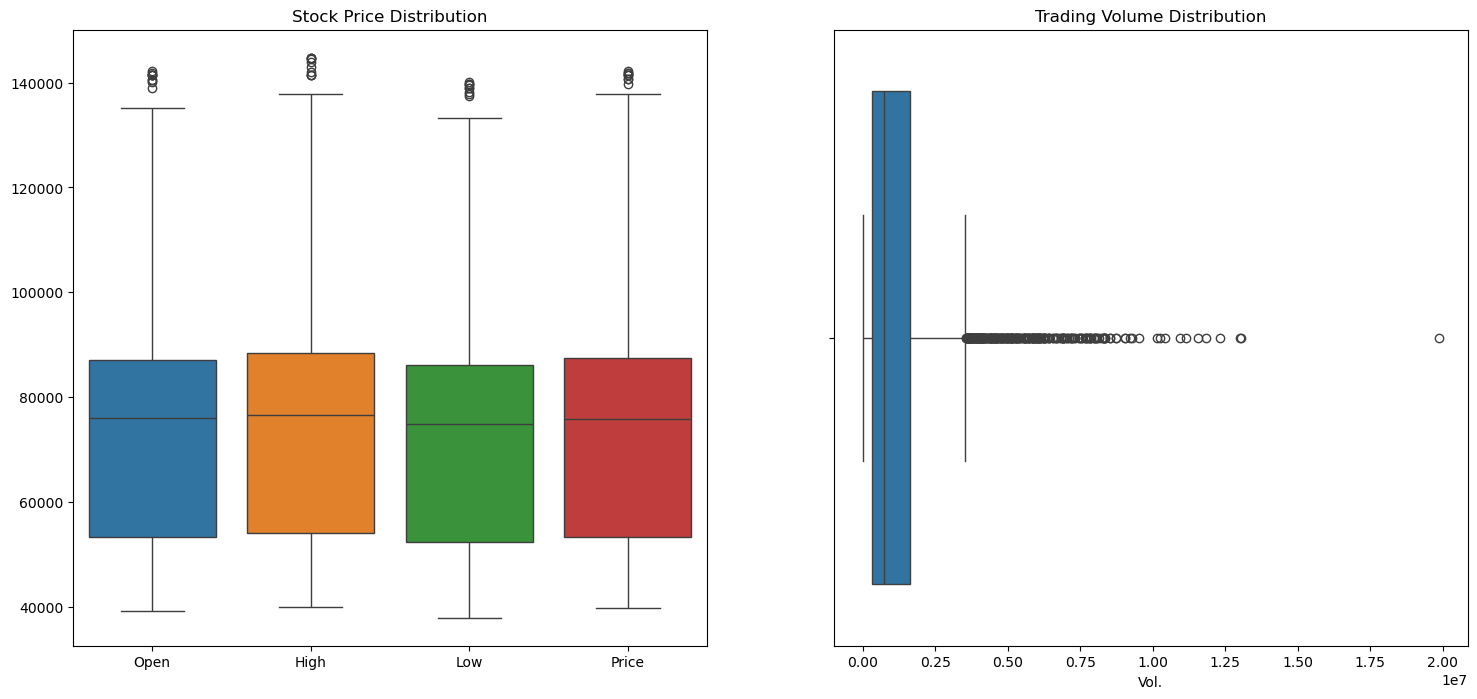

In [81]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Boxplot for Prices
sns.boxplot(data=df[["Open", "High", "Low", "Price"]], ax=axes[0])
axes[0].set_title("Stock Price Distribution")

# Boxplot for Volume
sns.boxplot(x=df["Vol."], ax=axes[1])
axes[1].set_title("Trading Volume Distribution")

plt.show()


In [82]:
# Calculate IQR
Q1 = df[["Open", "High", "Low", "Price"]].quantile(0.25)
Q3 = df[["Open", "High", "Low", "Price"]].quantile(0.75)
IQR = Q3 - Q1

# Define outlier limits
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((df[["Open", "High", "Low", "Price"]] < lower_bound) | 
            (df[["Open", "High", "Low", "Price"]] > upper_bound)).any(axis=1)

# Print number of outliers
print(f"Number of outliers: {outliers.sum()}")


Number of outliers: 10


In [103]:
# Compute IQR for Volume
Q1 = df["Vol."].quantile(0.25)
Q3 = df["Vol."].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
volume_outliers = (df["Vol."] < lower_bound) | (df["Vol."] > upper_bound)

# Print number of outliers
print(f"Number of outliers in Volume: {volume_outliers.sum()}")

Number of outliers in Volume: 266


- There are 10 outliers in columns "Open", "High", "Low", "Price", and 266 in "Vol."

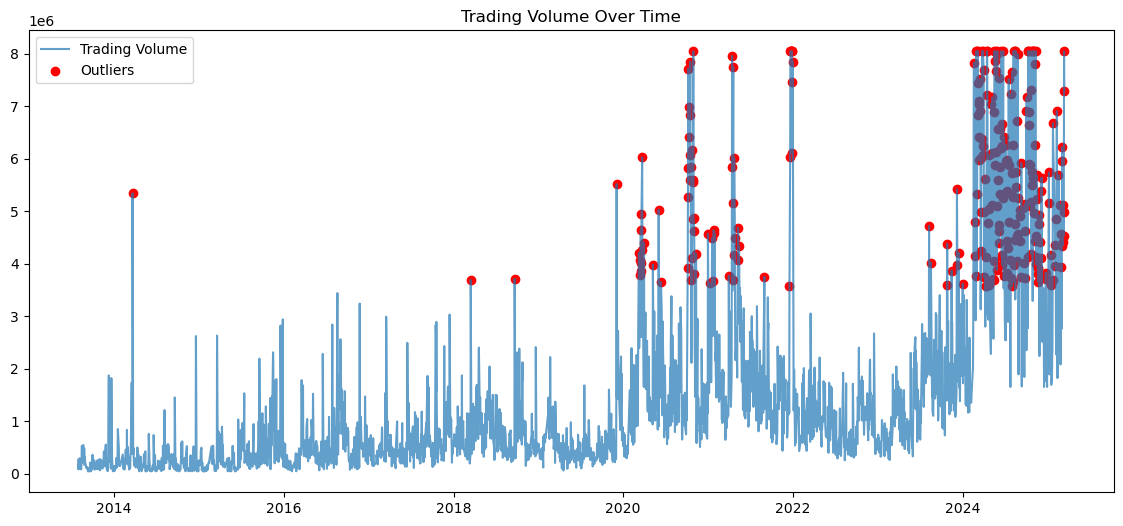

In [106]:
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Vol."], label="Trading Volume", alpha=0.7)
plt.scatter(df["Date"][volume_outliers], df["Vol."][volume_outliers], color='red', label="Outliers")
plt.legend()
plt.title("Trading Volume Over Time")
plt.show()


- Based on the plot, we can assume that the outliers in trading volume are market-driven 
- -> We can keep them and create a new feature Relative Volume (RVOL), which measures the change between today's volume and avg of past 30 days
- If RVOL > 1, it means volume is higher than usual, signaling potential trend changes.
- If RVOL < 1, it means trading activity is lower than normal.

In [107]:
df["Avg_Vol"] = df["Vol."].rolling(window=30).mean()
df["RVOL"] = df["Vol."] / df["Avg_Vol"]

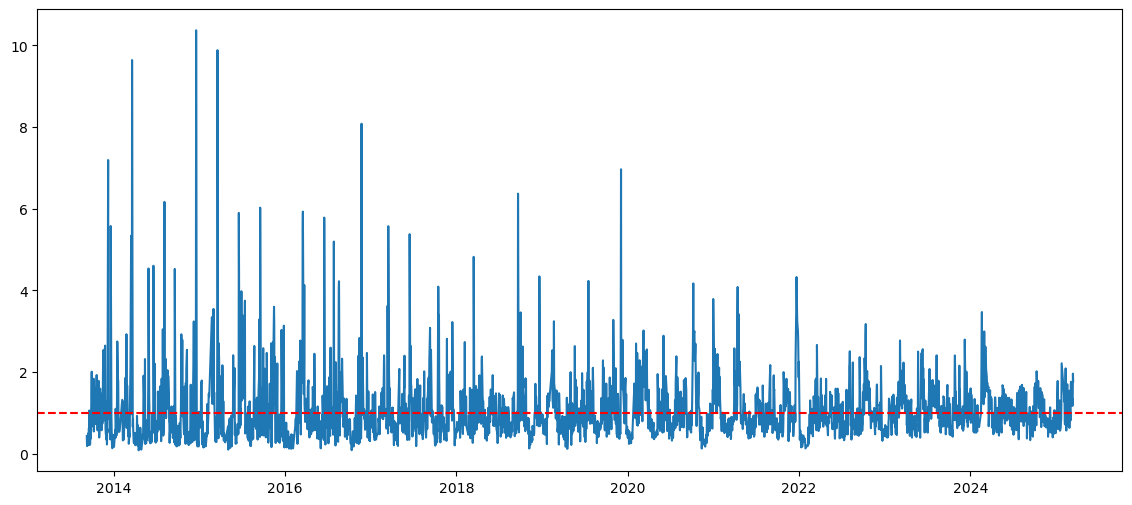

In [118]:
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["RVOL"])
plt.axhline(y=1, color="red", linestyle="--", label="y = 1")

### Check the distribution

In [127]:
df = df.drop(["Volo", "Avg_Vol"], axis=1)

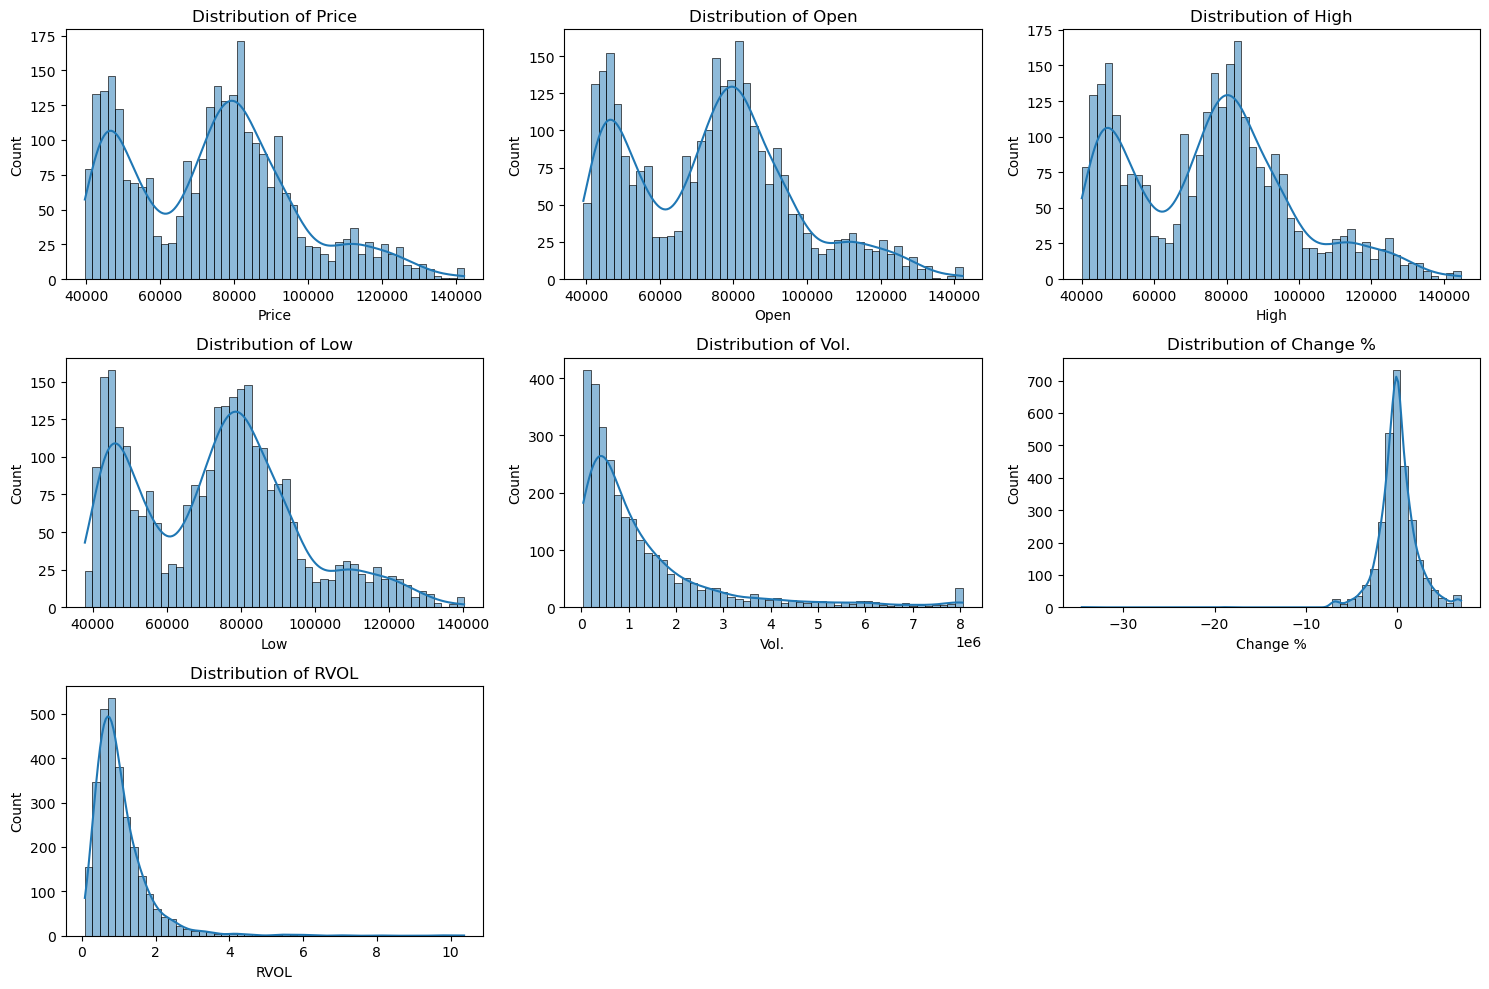

In [128]:
# Select only numerical columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Plot histograms for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Adjust subplot grid if needed
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()